# Continuous Variable VQE for long-range molecular interactions

In the following, we illustrate how our code can be used to study the system composed of a pair of QDO oscillators. We focus on a 1-dimensional model for efficiency, but the code generalized to the full-fledged 3d QDO model.

We focus on the case of a diatomic system.

## Imports

In [2]:
from datetime import datetime
from dataclasses import dataclass
import json
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import numpy as np
import os
import strawberryfields as sf
from strawberryfields.backends.tfbackend.states import FockStateTF
import tensorflow as tf

from src.energy_surface import EnergySurface

In [25]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

Let us define the following `Atom` dataclass to store the QDO parameters later

In [26]:
@dataclass
class Atom:
    m: float
    omega: float
    q: float

You can choose among the following list of atoms. Note that the 'Un' atom corresponds to a fictitious atom with unit parameters.

In [27]:
ATOMIC_PARAMETERS = {
    'Un': {'omega': 1.0000, 'm': 1.0000, 'q': 1.0000},
    'H':  {'omega': 0.4280, 'm': 0.8348, 'q': 0.8295},
    'Ne': {'omega': 1.1933, 'm': 0.3675, 'q': 1.1820},
    'Ar': {'omega': 0.6958, 'm': 0.3562, 'q': 1.3835},
    'Kr': {'omega': 0.6122, 'm': 0.3401, 'q': 1.4635},
    'Xe': {'omega': 0.5115, 'm': 0.3298, 'q': 1.5348},
}

## Preliminaries: defining the inputs of the simulation

Let us first define the various parameters relevant for the definition and the training of the model

In [28]:
args = {
    'layers': 8,
    'cutoff_dim': 5,
    'atom_list': ['Un', 'Un'],
    'active_sd': 0.0001,
    'passive_sd': 0.1,
    'learning_rate': 0.01,
    'epsilon': 1e-3,
    'patience': 30,
    'seed': 42,
    'save_dir': './logs/'
}

args['dimension'] = 1
args['modes'] = len(args['atom_list']) * args['dimension']

distances = list(np.linspace(0.1, 3.5, 70))
thetas = list(np.linspace(0.0, np.pi / 2, 20))

#distances = list(np.linspace(0.3, 3.5, 3))
#thetas = list(np.linspace(np.pi / 4, np.pi / 2, 2))

args['distance_list'] = distances
args['theta_list'] = thetas

args = objectview(args)

By default, Strawberry Fields sets $\hbar=2$. Let us redefine it to fit atomic units conventions

In [29]:
sf.hbar = 1.0

Let us also set the random seeds for reproducibility of the results

In [30]:
tf.random.set_seed(args.seed)
np.random.seed(args.seed)

Let us define a directory where to store the results of the simulation

Let us store the QDO's data into dataclass

In [31]:
atoms = []

for atom in args.atom_list:

    atoms.append(Atom(
        m=ATOMIC_PARAMETERS[atom]['m'],
        omega=ATOMIC_PARAMETERS[atom]['omega'],
        q=ATOMIC_PARAMETERS[atom]['q']
    ))

We work with the quadratures of the electromagnetic field, which are real valued variables, hence need to be discretized

In [32]:
x_quadrature_grid = np.linspace(-7.0, 7.0, 400)

## Training

We are finally ready to instanciate a `EnergySurface` object, whose ability is to run a VQE algorithm for each of the specified interatomic distances and angle/model, and store the results of the simulation in the directory defined previously.

In [ ]:
save_dir = os.path.join(
    args.save_dir,
    datetime.now().strftime("%Y.%m.%d.%H.%M.%S")
)

os.makedirs(save_dir, exist_ok=True)

# Save the parameters of the run to the log directory
with open(os.path.join(save_dir, 'args.json'), 'w') as f:
    json.dump(vars(args), f, indent=4)

energy_surface = EnergySurface(
    layers=args.layers,
    distance_list=distances,
    theta_list=thetas,
    x_quadrature_grid=x_quadrature_grid,
    atoms=atoms,
    active_sd=args.active_sd,
    passive_sd=args.passive_sd,
    cutoff_dim=args.cutoff_dim,
    learning_rate=args.learning_rate,
    save_dir=save_dir,
    verbose=False
)

res = energy_surface.construct_energy_surface_parallelized(
    epsilon=args.epsilon,
    patience=args.patience
)

## Postprocessing

Let us load the results of the simulation

In [3]:
dir = 'logs/2023.02.16.18.16.16/'
res = np.load(os.path.join(dir, 'results.npy'))

binding_energies = res[:, :, -1, -1]
states = res[:, :, :-1, :-1]
distances = np.load(os.path.join(dir, 'distance_array.npy'))
thetas = np.load(os.path.join(dir, 'angle_array.npy'))
quadrature_grid = np.load(os.path.join(dir, 'quadrature_array.npy'))

We export the data to Mathematica readable format in order to do interpolations and output beautiful plots

In [19]:
mathematica_dir = os.path.join('mathematica', dir.split('/')[1])
os.makedirs(mathematica_dir, exist_ok=True)

In [ ]:
distances.astype('float32').tofile(os.path.join(mathematica_dir, 'distances.dat'))
thetas.astype('float32').tofile(os.path.join(mathematica_dir, 'angles.dat'))
binding_energies.astype('float32').tofile(os.path.join(mathematica_dir, 'binding_energies.dat'))
states.astype('float32').tofile(os.path.join(mathematica_dir, 'states.dat'))
quadrature_grid.astype('float32').tofile(os.path.join(mathematica_dir, 'quadrature_grid.dat'))

### Plotting the binding curve

In [5]:
def plot_binding_curve(
    distance_array: np.ndarray,
    binding_energy_array: np.ndarray
) -> None:
    
    fig, axes = plt.subplots(nrows=1, ncols=1)
    #axes.scatter(distance_array[4:], binding_energy_array[4:], s=10)
    axes.plot(distance_array, binding_energy_array)
    axes.set_xlabel('Interatomic distance')
    axes.set_ylabel('Binding energy')
    axes.grid(True)
    axes.set_title('Potential energy surface')
    plt.show()
    #plt.savefig(save_path, dpi=300, transparent=False, bbox_inches='tight')

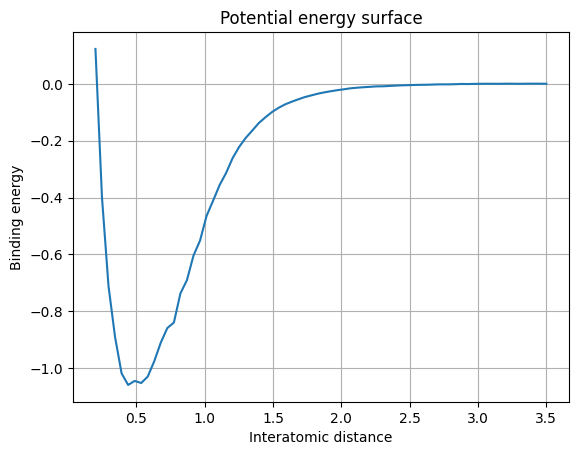

In [39]:
plot_binding_curve(
    distance_array=distances,
    binding_energy_array=binding_energies[2]
)

### Entanglement entropy

In [15]:
from math import log
from scipy import linalg

def von_neumann_entropy(states: np.ndarray) -> np.ndarray:
    r""" Computes the von neumann entropy of a the partial density matrix
    of the first subsystem of the total system described by state `alpha`.
    Note that this function does not support more than a two-mode system for now.

    Args:
        alpha (np.ndarray): The coefficients of the state of the total system expressed in the Fock basis.
    Returns:
        (float): The von neumann entropy of the first subsystem.
    """

    # Let us compute the partial density matrix of the first
    # subsystem, expressed in the Fock basis
    rho = np.einsum('abml,abnl->abnm', states.conjugate(), states)

    entropy_array = np.zeros(shape=(states.shape[0], states.shape[1]))

    # Unfortunately the log of a matrix is computed with `linalg.logm`,
    # which doesn't have a vectorized implementation, so one should loop.
    for i in range(entropy_array.shape[0]):
        for j in range(entropy_array.shape[1]):

            # We finally compute the von Neumann entropy (log base 2)
            entropy = - (1 / log(2)) * np.trace(rho[i, j] @ linalg.logm(rho[i, j]))
            entropy_array[i, j] = entropy

    return entropy_array

In [17]:
entropy_array = von_neumann_entropy(states=states)

In [18]:
entropy_array.shape

(9, 70)

In [20]:
entropy_array.astype('float32').tofile(os.path.join(mathematica_dir, 'entropies.dat'))

In [21]:
def plot_entropy(
    distance_array: np.ndarray,
    entropy_array: np.ndarray
) -> None:
    
    fig, axes = plt.subplots(nrows=1, ncols=1)
    #axes.scatter(distance_array[4:], binding_energy_array[4:], s=10)
    axes.plot(distance_array, entropy_array)
    axes.set_xlabel('Interatomic distance')
    axes.set_ylabel('Binding energy')
    axes.grid(True)
    axes.set_title('Entanglement entropy')
    plt.show()
    #plt.savefig(save_path, dpi=300, transparent=False, bbox_inches='tight')

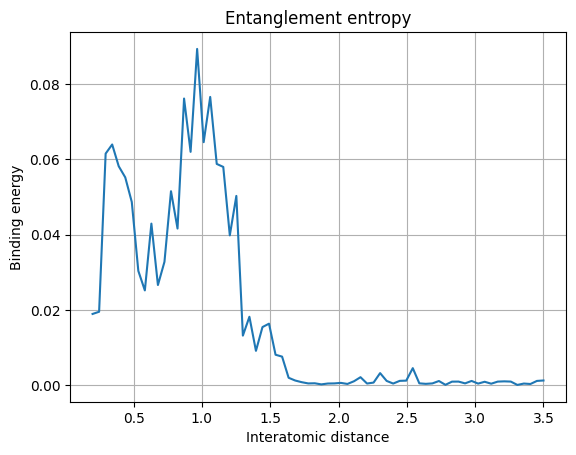

In [41]:
plot_entropy(
    distance_array=distances,
    entropy_array=entropy_array[3]
)

### Wigner functions vizualization

In [ ]:
import glob

directory = 'logs/2023.02.16.10.49.17/theta=0.5890'
fig_dir = os.path.join(directory, 'figures')
os.makedirs(fig_dir, exist_ok=True)

X, P = np.meshgrid(x_quadrature_grid, x_quadrature_grid)

states = glob.glob(os.path.join(directory, 'states', 'distance=*'))
states.sort()
states = states[0:]

for file in states:
    
    distance = file.split('=')[2].split('.npy')[0]
    state_data = np.load(file)
    state = FockStateTF(state_data=state_data, num_modes=args.modes, pure=True, cutoff_dim=args.cutoff_dim)

    w_qdo1 = state.wigner(mode=0, xvec=x_quadrature_grid, pvec=x_quadrature_grid)
    w_qdo2 = state.wigner(mode=1, xvec=x_quadrature_grid, pvec=x_quadrature_grid)

    fig = plt.figure(figsize=(11, 8))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot_surface(X, P, w_qdo1, cmap=cm.coolwarm, lw=0.5, rstride=1, cstride=1)
    ax1.set_axis_off()
    ax1.set_title("QDO 1")
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot_surface(X, P, w_qdo1, cmap=cm.coolwarm, lw=0.5, rstride=1, cstride=1)
    ax2.set_axis_off()
    ax2.set_title("QDO 2")
    plt.savefig(os.path.join(fig_dir, distance + '.png'))
    plt.close()

## Marginal densities vizualization

In [ ]:
import glob

directory = 'logs/2023.02.16.10.49.17/theta=0.5890'
fig_dir = os.path.join(directory, 'figures')
os.makedirs(fig_dir, exist_ok=True)

states = glob.glob(os.path.join(directory, 'quad_marginals/distance=*'))
states.sort()
states = states[start:]

for file in states:
    
    distance = file.split('=')[2].split('.npy')[0]
    data = np.load(file)
    state = FockStateTF(state_data=data, num_modes=args.modes, pure=True, cutoff_dim=args.cutoff_dim)

    rho1 = data[0]
    rho2 = data[1]

    fig = plt.figure(figsize=(11, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x_quadrature_grid, rho1)
    ax.plot(x_quadrature_grid, rho2)
    ax.set_xlabel('Position relative to QDO center')
    ax.set_title("Marginal position quadrature densities")
    plt.yticks([])
    plt.savefig(os.path.join(fig_dir, distance + '.png'))
    plt.close()

## Joint density vizualization

In [ ]:
import glob

directory = 'logs/model=30/2023.02.08.16.41.09'
fig_dir = os.path.join(directory, 'figures')
os.makedirs(fig_dir, exist_ok=True)

X1, X2 = np.meshgrid(x_quadrature_grid, x_quadrature_grid)

states = glob.glob(os.path.join(directory, 'quad_density/density_d=*'))
states.sort()
states = states[start:]

for file in states:
    
    distance = file.split('=')[2].split('.npy')[0]
    joint_density = np.load(file)

    fig = plt.figure(figsize=(11, 8))
    ax1 = fig.add_subplot(1, 1, 1, projection='3d')
    ax1.plot_surface(X1, X2, joint_density, cmap=cm.coolwarm, lw=0.5, rstride=1, cstride=1)
    ax1.set_axis_off()
    ax1.set_title("Position quadratures joint density")
    plt.savefig(os.path.join(fig_dir, distance + '.png'))
    plt.close()